In [1]:
import numpy as np
import pandas as pd


from scipy.stats import norm, uniform


def generate_frontdoor_nonlinear_df(sample_size = 1500, seed = 123):
    np.random.seed(seed)
    # Generate random samples
    N = sample_size
    U = np.random.normal(0, 1, N)
    X_prime = np.random.uniform(-2, 2, N)

    # Calculate X
    X = X_prime + U

    # Calculate Z
    Z = 4 * norm.pdf(X) + np.random.normal(0, 0.1, N)

    # Calculate Y
    Y = norm.pdf(Z - 0.5) + 0.3 * Z - 0.1 * U

    df = pd.DataFrame(np.vstack([X, Z, Y]).T, columns=['X', 'Z', 'Y'])
    return df

# Visualisations

In [ ]:
import numpy as np
import pandas as pd


from scipy.stats import norm, uniform

# Generate random samples
N = 1500
U = np.random.normal(0, 1, N)
X_prime = np.random.uniform(-2, 2, N)

# Calculate X
X = X_prime + U

# Calculate Z
Z = 4 * norm.pdf(X) + np.random.normal(0, 0.1, N)

# Calculate Y
Y = norm.pdf(Z - 0.5) + 0.3 * Z - 0.1 * U

df = pd.DataFrame(np.vstack([X, Z, Y]).T, columns=['X', 'Z', 'Y'])


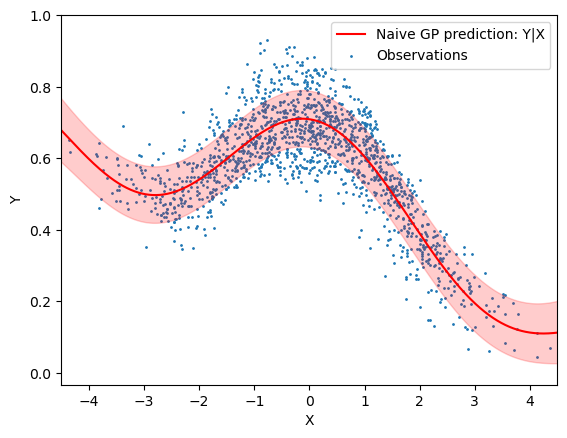

In [ ]:
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
# Create a DataFrame with X, Y, and Z
data = pd.DataFrame({'X': X, 'Y': Y, 'Z': Z})

# Select a subsample of 500 observations
subsample = data.sample(n=500, random_state=42)

# Create a scatterplot matrix
#scatter_matrix(subsample, alpha=0.2, figsize=(8, 8), diagonal='kde')


# Define the kernel function for the GP
kernel = 1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) \
    + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))

## Define the kernel for the Gaussian process (Linear Kernel + White Kernel for noise)
#kernel = DotProduct() + WhiteKernel()

# Initialize the GP with the kernel function
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0)

# Fit the GP to the data
gp.fit(X.reshape(-1, 1), Y.reshape(-1, 1))

# Generate some test data to evaluate the GP
X_test = np.linspace(-5.5, 5.5, N).reshape(-1, 1)

# Use the GP to make predictions
y_pred, std = gp.predict(X_test, return_std=True)

plt.plot(X_test, y_pred, 'r-', label='Naive GP prediction: Y|X')
plt.scatter(X, Y, s= 1, label='Observations')
plt.fill_between(X_test.ravel(), y_pred - std, y_pred + std,
                 alpha=0.2, color='r')
# Display the plot
plt.xlim(-4.5,4.5)

plt.xlabel("X")
plt.ylabel("Y")
#plt.plot(X_do_x, EV_y_do_x, 'k-', label='E[Y|do(X)] : True')
plt.legend()
plt.show()

# Interventional Distribution: do(X=x)

In [ ]:

U = np.random.normal(0, 1, N)
X_prime = np.random.uniform(-2, 2, N)

# Calculate X
X_do_x = np.linspace(-5, 5, N)

# Calculate Z
Z_do_x = 4 * norm.pdf(X_do_x) + np.random.normal(0, 0.1, N)

# Calculate Y
Y_do_x = norm.pdf(Z_do_x - 0.5) + 0.3 * Z_do_x - 0.1 * U
X_do_x = np.linspace(-5.5, 5.5, N)
EV_y_do_x  = norm.pdf((4 * norm.pdf(X_do_x)) - 0.5)  + 0.3 *(4 * norm.pdf(X_do_x)) 

# Frontdoor

## Gaussian process (GP)

In [ ]:

X_test = X_do_x.reshape(-1, 1)

# Initialize the GP with the kernel function
gp_fd1= GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9,  alpha=0.0)

# Fit the GP to the data
gp_fd1.fit(X.reshape(-1, 1), Z.reshape(-1, 1))

# Use the GP to make predictions
z_pred_fd1, std_fd1 = gp_fd1.predict(X.reshape(-1, 1), return_std=True)

z_pred_fd1_for_vis, std_fd1 = gp_fd1.predict(X_test, return_std=True)

# Initialize the GP with the kernel function
gp_fd2 = GaussianProcessRegressor(kernel=kernel,  n_restarts_optimizer=9,  alpha=0.0)

# Fit the GP to the data
gp_fd2.fit(np.stack((X, Z), axis=-1), Y.reshape(-1, 1))


# Use the GP to make predictions    
#y_pred_fd2, std_fd2 = gp_fd2.predict(np.stack((X_test.flatten(), z_pred_fd1_for_vis.flatten()), axis=-1), return_std=True)



GaussianProcessRegressor(alpha=0.0,
                         kernel=1**2 * RBF(length_scale=100) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=9)

In [ ]:
def average_std(std_arr):
    return 1 / len(std_arr) * np.sqrt(np.square(std_arr).sum() ) 

y_pred_fd2 = []
y_pred_fd2_std = []
z_i_vector =  gp_fd1.sample_y(X_test, N)
for i in range(N):
    print(i,  " from ", N)
    #print(np.mean(gp_fd2.predict(np.stack((X, np.full((N,),z_pred_fd1_for_vis[i])), axis=-1))))
    # E[Y| do(X = X_test)] = mean( E[Y| X = x_i, Z= z_i] ) with   z_i ~  Z| x
    # y_pred_fd2.append(np.mean(gp_fd2.predict(np.stack((X, np.full((N,),z_pred_fd1_for_vis[i])), axis=-1))))
    y_pred_fd2_i, std_fd2_i = gp_fd2.predict(np.stack((X, np.full((N,), z_i_vector[i])), axis=-1),return_std=True )
    #y_pred_fd2_std.append(np.sqrt(np.sum(std_fd2_i**2)) / np.sqrt(N) )
    print(np.std(y_pred_fd2_i) + average_std(std_fd2_i))
    y_pred_fd2_std.append(np.std(y_pred_fd2_i) + average_std(std_fd2_i))
    y_pred_fd2.append(np.mean(y_pred_fd2_i))

In [ ]:
y_pred_fd2 = []
y_pred_fd2_std = []
z_i_vector =  gp_fd1.sample_y(X_test, N)
for i in range(N):
    print(i,  " from ", N)
    #print(np.mean(gp_fd2.predict(np.stack((X, np.full((N,),z_pred_fd1_for_vis[i])), axis=-1))))
    # E[Y| do(X = X_test)] = mean( E[Y| X = x_i, Z= z_i] ) with   z_i ~  Z| x
    # y_pred_fd2.append(np.mean(gp_fd2.predict(np.stack((X, np.full((N,),z_pred_fd1_for_vis[i])), axis=-1))))
    y_pred_fd2_i, std_fd2_i = gp_fd2.predict(np.stack((X, np.full((N,), z_i_vector[i])), axis=-1),return_std=True )
    #y_pred_fd2_std.append(np.sqrt(np.sum(std_fd2_i**2)) / np.sqrt(N) )
    y_pred_fd2_std.append(np.std(y_pred_fd2_i))
    y_pred_fd2.append(np.mean(y_pred_fd2_i))    

0  from  1500
1  from  1500
2  from  1500
3  from  1500
4  from  1500
5  from  1500
6  from  1500
7  from  1500
8  from  1500
9  from  1500
10  from  1500
11  from  1500
12  from  1500
13  from  1500
14  from  1500
15  from  1500
16  from  1500
17  from  1500
18  from  1500
19  from  1500
20  from  1500
21  from  1500
22  from  1500
23  from  1500
24  from  1500
25  from  1500
26  from  1500
27  from  1500
28  from  1500
29  from  1500
30  from  1500
31  from  1500
32  from  1500
33  from  1500
34  from  1500
35  from  1500
36  from  1500
37  from  1500
38  from  1500
39  from  1500
40  from  1500
41  from  1500
42  from  1500
43  from  1500
44  from  1500
45  from  1500
46  from  1500
47  from  1500
48  from  1500
49  from  1500
50  from  1500
51  from  1500
52  from  1500
53  from  1500
54  from  1500
55  from  1500
56  from  1500
57  from  1500
58  from  1500
59  from  1500
60  from  1500
61  from  1500
62  from  1500
63  from  1500
64  from  1500
65  from  1500
66  from  1500
67  f

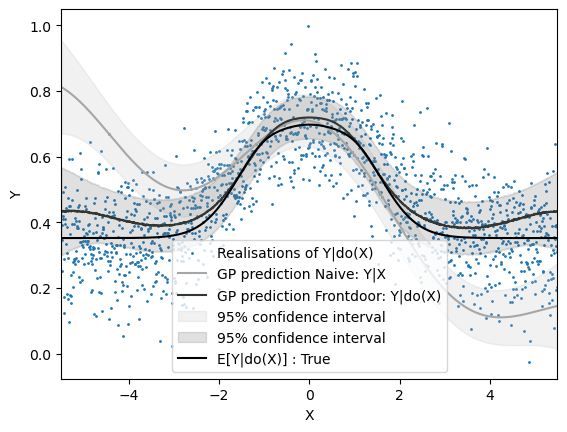

In [ ]:
y_pred_fd2_std = np.array(y_pred_fd2_std)
plt.scatter(X_do_x, Y_do_x, s= 1, label='Realisations of Y|do(X)')
plt.plot(X_test, y_pred, color='#a6a6a6', label='GP prediction Naive: Y|X')
plt.plot(X_test, y_pred_fd2, color='#343634', label='GP prediction Frontdoor: Y|do(X)')

plt.fill_between(X_test.ravel(), y_pred - std, y_pred + std,
                 alpha=0.2, color='#bdbbbb', label=r'95% confidence interval')
plt.fill_between(X_test.ravel(), y_pred_fd2 - y_pred_fd2_std, y_pred_fd2 + y_pred_fd2_std,
                 alpha=0.2, color='#656665', label=r'95% confidence interval')
# Display the plot
plt.plot(X_do_x, EV_y_do_x, 'k-', label='E[Y|do(X)] : True')
plt.legend()

mean_linear = 0.002	
sd_linear = 0.002
#plt.plot(X_test, np.full((N,), mean_linear), color='b')
#plt.fill_between(X_test.ravel(), mean_linear - sd_linear, mean_linear + sd_linear,
#                 alpha=0.2, color='b', label=r'95% confidence interval')
plt.xlim(-5.5,5.5)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

# Comparative Study: OLS poly feature expantion (d = 3) vs. GP RBF

In [2]:
def generate_test_df(N = 2000):    
    U = np.random.normal(0, 1, N)
    # Calculate Xe 
    X_do_x = np.linspace(-4, 4, N)
    # Calculate Z
    Z_do_x = 4 * norm.pdf(X_do_x) + np.random.normal(0, 0.1, N)
    # Calculate Y
    Y_do_x = norm.pdf(Z_do_x - 0.5) + 0.3 * Z_do_x - 0.1 * U
    EV_y_do_x  = norm.pdf((4 * norm.pdf(X_do_x)) - 0.5)  + 0.3 *(4 * norm.pdf(X_do_x)) 
    return X_do_x, Y_do_x, EV_y_do_x  



In [36]:
### generating test data for BART
#X_do_x, Y_do_x, EV_y_do_x  = generate_test_df()
#pd.DataFrame({'X_do_x':X_do_x, 'Y_do_x':Y_do_x, 'EV_y_do_x':EV_y_do_x }).to_csv("datasets_bachelorthesis/frontdoor_nonlinear/frontdoor_nonlinear_test_data.csv", index= False)

In [199]:
def ols_poly_feature_adrf(df):
    from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
    from sklearn.linear_model import LinearRegression
    from sklearn.pipeline import make_pipeline
    X_do_x, Y_do_x, EV_y_do_x  = generate_test_df(N = 2000)
    data = df
    # Fit the first OLS model: Z ~ X
    degree = 5 # You can change this to the desired degree of the polynomial
    # Fit and transform the first OLS model: Z ~ X
    model_Z_X = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model_Z_X.fit(data[['X']], data['Z'])
    predictions_Z = model_Z_X.predict(np.array(data['X']).reshape(-1, 1))
    prediction_Z_do_x = model_Z_X.predict((np.array(X_do_x).reshape(-1, 1)))
    # Fit and transform the second OLS model: Y ~ X + Z
    model_Y_XZ = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model_Y_XZ.fit(data[['X', 'Z']], data['Y'])
    predictions_Y = model_Y_XZ.predict(data[['X', 'Z']])
    predictions_Y_do_x = []
    for i in range(len(prediction_Z_do_x)):
        y_pred_i =  model_Y_XZ.predict(np.stack((df['X'].values, np.full((len(data),), prediction_Z_do_x[i])), axis=-1) )
        predictions_Y_do_x.append(np.mean(y_pred_i))
    return X_do_x,predictions_Y_do_x, Y_do_x, EV_y_do_x

In [ ]:
# Calcualting mse
ols_poly_rsme_list = []
from sklearn.metrics import mean_squared_error
for N in [100, 500, 1000, 2000]:
    df =  generate_frontdoor_nonlinear_df(sample_size = N)
    X_do_x, y_do_x_pred, Y_do_x, EV_y_do_x = ols_poly_feature_adrf(df)
    rms = mean_squared_error(EV_y_do_x, y_do_x_pred, squared= False)
    ols_poly_rsme_list.append(rms)


In [195]:
print(ols_poly_rsme_list) # N = 3

[0.8289069009799764, 0.40840411383769876, 0.46873952771820093, 0.36477224065642677]


## Linear Regression OLS (doesn't make sense to use in NON-linear)

In [ ]:
from sklearn.linear_model import LinearRegression
data = df
# Fit the first OLS model: Z ~ X
model_Z_X = LinearRegression().fit(data[['X']], data['Z'])

predictions_Z = model_Z_X.predict(data['X'].values.reshape(-1, 1))
# Get predictions for Z
Z_do_X= model_Z_X.predict(np.array(X_do_x).reshape(-1, 1))

X_and_Z = np.concatenate((data['X'].values.reshape(-1, 1), predictions_Z.reshape(-1, 1)), axis=1)
# Fit the second OLS model: Y ~ X + Z
model_Y_XZ = LinearRegression().fit(data[['X', 'Z']], data['Y'])


X_and_Z_do_x = np.concatenate((np.array(X_do_x).reshape(-1, 1), Z_do_X.reshape(-1, 1)), axis=1)

# Get predictions for Y
Y_do_x = []

for i in range(len(Z_do_X)):
    y_pred_i =  model_Y_XZ.predict(np.stack(( df['X'].values, np.full((len(data),), Z_do_X[i])), axis=-1) )
    Y_do_x.append(np.mean(y_pred_i))

In [9]:
def average_std(std_arr):
    return 1 / len(std_arr) * np.sqrt(np.square(std_arr).sum()) 

## Gaussian process Regression (RBF)

In [28]:
def gp_rbf_fd_cont_t(df):  
    from sklearn.gaussian_process import GaussianProcessRegressor
    from sklearn.gaussian_process.kernels import RBF, WhiteKernel
    X_do_x, Y_do_x, EV_y_do_x  = generate_test_df(N = 2000)
    N = len(X_do_x)
    kernel = 1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3)) \
        + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1))
    # Initialize the GP with the kernel function
    gp_fd1= GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=11,  alpha=0.0)
    # Fit the GP to the data
    gp_fd1.fit(np.array(df.X).reshape(-1, 1), df.Z)
    z_pred_do_x, std_fd1 = gp_fd1.predict(np.array(X_do_x).reshape(-1, 1), return_std=True)
    # Initialize the GP with the kernel function
    gp_fd2 = GaussianProcessRegressor(kernel=kernel,  n_restarts_optimizer=11,  alpha=0.0)
    gp_fd2.fit(np.stack((df.X, df.Z), axis=-1), df.Y)
    # Fit the GP to the data
    y_pred_fd2 = []
    y_pred_fd2_std = []
    z_i_vector =  gp_fd1.sample_y(np.array(X_do_x).reshape(-1, 1), len(df))
    for i in range(N):
        print(i,  " from ", N)
        # E[Y| do(X = X_test)] = mean( E[Y| X = x_i, Z= z_i] ) with   z_i ~  Z| x
        # y_pred_fd2.append(np.mean(gp_fd2.predict(np.stack((X, np.full((N,),z_pred_fd1_for_vis[i])), axis=-1))))
        y_pred_fd2_i, std_fd2_i = gp_fd2.predict(np.stack((df.X, np.full((len(df),), z_i_vector[i])), axis=-1),return_std=True )
        #y_pred_fd2_std.append(np.sqrt(np.sum(std_fd2_i**2)) / np.sqrt(N) )
        y_pred_fd2_std.append(average_std(std_fd2_i))
        y_pred_fd2.append(np.mean(y_pred_fd2_i))
    return X_do_x, y_pred_fd2, y_pred_fd2_std, Y_do_x, EV_y_do_x


### exoprt dataset for BART

In [34]:
#for N in [100, 500, 1000, 2000]:
#    df =  generate_frontdoor_nonlinear_df(sample_size = N)
#    df.to_csv(f"datasets_bachelorthesis/frontdoor_nonlinear/frontdoor_nonlinear_"+ str(N)+ '.csv', index= False)

In [ ]:
# Calcualting mse
gp_rsme_list = []
from sklearn.metrics import mean_squared_error
for N in [100, 500, 1000, 2000]:
    df =  generate_frontdoor_nonlinear_df(sample_size = N)
    X_do_x, y_do_x_pred,y_do_x_pred_std, Y_do_x, EV_y_do_x = gp_rbf_fd_cont_t(df)
    rms = mean_squared_error(EV_y_do_x, y_do_x_pred, squared= False)
    gp_rsme_list.append(rms)

In [31]:
print(gp_rsme_list)

[0.0925897395249874, 0.0430074181587903, 0.03069301165692788, 0.013508610846598618]
